In [1]:
%run "../../shared/utilz_image_proc.ipynb"

# Train CNN & Live Digit Recognition
- Libraries used
    - `openCV`: Webcam, image manipulation 
    - `sklearn`: metrics, train_test_split, 
    - `keras`: with `tensor` for CNN 
    - usual suspects: `numpy`, `matplotlib`
    

In [2]:
import os, glob

## 1. Dataset and Training
- 

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
## split and scale data

In [5]:
DIR_TRAIN_SET = "../../datasets/myData"
CHAR_DIRZ = list(range(0,10))
CHAR_DIRZ = os.listdir( DIR_TRAIN_SET)

In [6]:
## read images into matrix of 
x_size = (32, 32)
n_classez = len( CHAR_DIRZ ) 
x_imagez = []
y_labelz = []


# a. import the images 
printHeadline('','Load Learning Dataset' )

print(f'Loading images of digit: ', end=' ')
for x in range(0, n_classez):
    filez = os.listdir( f"{DIR_TRAIN_SET}/{x}" )
    for f in filez:
        i = cv2.resize(cv2.imread( f"{DIR_TRAIN_SET}/{x}/{f}" ) , x_size )
        x_imagez.append( i )
        y_labelz.append( x )
    #print(f'Loaded {len(filez)} images of digit {x}')
    print(f'{x}', end=' ')
print('')
x_imagez = np.array( x_imagez)
y_labelz = np.array( y_labelz )

print(f'Loaded: {len(y_labelz)} Digits as {x_imagez.shape} images matrix')


------ 1.  : Load Learning Dataset ------
Loading images of digit:  0 1 2 3 4 5 6 7 8 9 
Loaded: 10160 Digits as (10160, 32, 32, 3) images matrix


In [7]:
dsetz = ['x_train', 'y_train', 'x_test',  'y_test', 'x_validation', 'y_validation']
printHeadline('','Split Dataset' )
perc_test = 0.2
perc_validation = 0.1
# b. Split data into train, test and validate <<sklearn:train_test_split shuffles and split
x_train, x_test, y_train, y_test = train_test_split(x_imagez, y_labelz, test_size=perc_test)

# c. split train data into train and validation 
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=perc_validation)

print(f'Split data into {perc_test*100} % test and {perc_validation*100} % of train as validation ')
for d in dsetz:    
    tmp = eval(d) #getattr(?, d), eval(d)
    print(f'\t{d}: \t\t{len(tmp)} \t{tmp.shape}')



------ 2.  : Split Dataset ------
Split data into 20.0 % test and 10.0 % of train as validation 
	x_train: 		7315 	(7315, 32, 32, 3)
	y_train: 		7315 	(7315,)
	x_test: 		2032 	(2032, 32, 32, 3)
	y_test: 		2032 	(2032,)
	x_validation: 		813 	(813, 32, 32, 3)
	y_validation: 		813 	(813,)



------ 3.  : Check that balanced samples ------


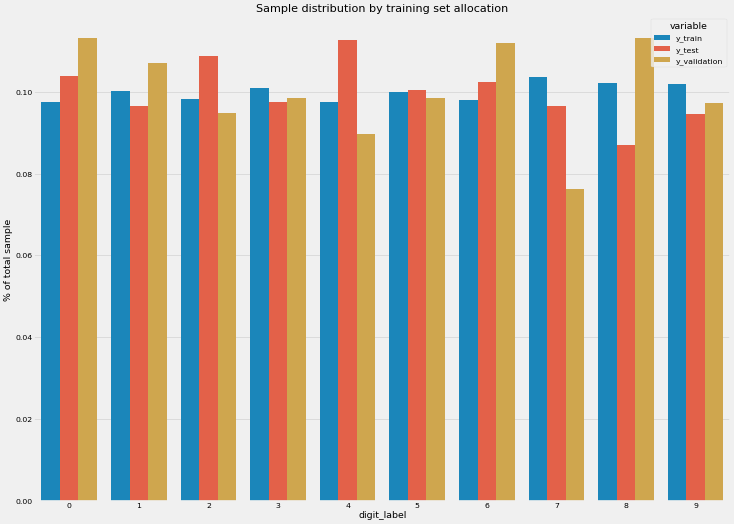

In [8]:
printHeadline('','Check that balanced samples' )

colz = [d for d in dsetz if d.startswith("y_")]
df = []
for y in colz:
    tmp = eval(y)
    tally = pd.Series( tmp).value_counts( normalize=True, sort=False) 
    #tmp = tally.reset_index()
    tally.columns = [ f'{y}_prop'] #'label',
    df.append(  tally )

df = pd.concat( df, join='inner', axis=1)
df = df.reset_index()
df.columns = ['digit_label', *colz]
df = df.melt(id_vars=['digit_label'], value_vars=list(df.columns)[1:] )
# df = df.reset_index()
# df.head()
sns.barplot( x='digit_label', y='value', hue='variable', data=df)
plt.ylabel( "% of total sample ")
plt.title('Sample distribution by training set allocation');

In [9]:
printHeadline('','Preprocess Images' )
def preprocess(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gimg = cv2.equalizeHist( gimg ) 
    gimg = gimg / 255 ## normalize
    return gimg


# grid_plot_images( [preprocess(i) for i in x_train[:10] ], logit=True, nc=5)


------ 4.  : Preprocess Images ------


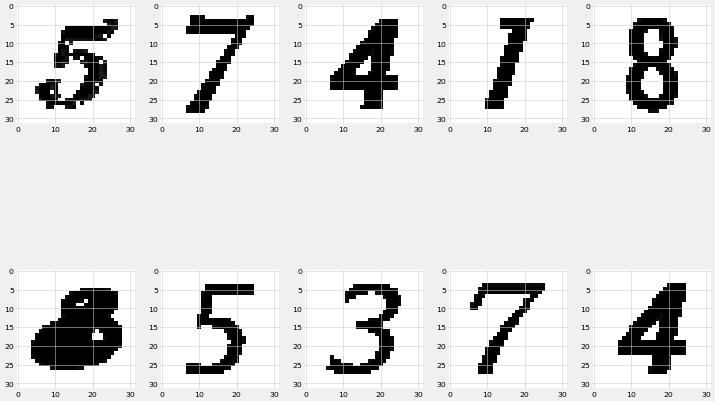

In [10]:
## run preprocess on all datasets
x_train = np.array( list(map(preprocess, x_train) ) )
x_test = np.array( list(map(preprocess, x_test) ) )
x_validation = np.array( list(map(preprocess, x_validation) ) )

grid_plot_images( x_train[:10], logit=False, nc=5)

In [11]:
## add a depth of 1 for CNN 
x_train = x_train.reshape( *x_train.shape, 1)
x_test = x_test.reshape( *x_test.shape, 1)
x_validation = x_validation.reshape( *x_validation.shape, 1)

for x in [d for d in dsetz if d.startswith("x_")]:
    print(f'{x}  \treshaped to \t{eval(x).shape}')

x_train  	reshaped to 	(7315, 32, 32, 1)
x_test  	reshaped to 	(2032, 32, 32, 1)
x_validation  	reshaped to 	(813, 32, 32, 1)


In [12]:
### ---- Rotate, warp images for more real-like user input
printHeadline('','Generate Image variations' )

## a. create generator
from keras.preprocessing.image import ImageDataGenerator

img_d_generator = ImageDataGenerator(
                    width_shift_range=0.1, #10%
                    height_shift_range=0.1, 
                    zoom_range=0.2,
                    shear_range=0.1,
                    rotation_range=10 #degrees
                    )
## b. setup by generator by calc some stats before transform and do transform during training in batchmode
img_d_generator.fit(x_train) 




------ 5.  : Generate Image variations ------


Using TensorFlow backend.


In [13]:
### --- Onehot encode class_labels b/c???
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, n_classez)
y_test = to_categorical(y_test, n_classez)
y_validation = to_categorical(y_validation, n_classez)


## 2. Model setup

In [14]:
def linet_model():
    n_filterz = 60
    k_filter1 = (5,5)
    k_filter2 = (3,3)
    k_pool = (2,2)
    n_nodez = 500
    
    model = keras.models.Sequential()
    # i. convolution layers @ 1st round ==> 
    model.add( keras.layers.Conv2D(n_filterz, k_filter1, 
                                   input_shape=(*x_size, 1),
                                   activation='relu'
                                  ) )
    model.add( keras.layers.Conv2D(n_filterz, k_filter1, activation='relu') )
    
    model.add( keras.layers.MaxPooling2D(pool_size=k_pool)) 
    
    # ii. convolution layers second round ==>
    model.add( keras.layers.Conv2D(n_filterz//2, k_filter2, activation='relu') )
    model.add( keras.layers.Conv2D(n_filterz//2, k_filter2, activation='relu') )
    
    model.add( keras.layers.MaxPooling2D(pool_size=k_pool))     
    # Dropout @ regularization    
    model.add( keras.layers.Dropout(0.5) ) 
    
    # iii. 
    model.add( keras.layers.Flatten() )    
    model.add( keras.layers.Dense(n_nodez, activation='relu') )    
    model.add( keras.layers.Dropout(0.5) ) 
    
    # iv. outputz
    model.add( keras.layers.Dense(n_classez, activation='softmax') )    
    
    
    model.compile( optimizer=keras.optimizers.Adam(lr=0.001),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model


cnn_model = linet_model()

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

In [15]:
printHeadline('CNN', 'Run Training')

## train in batches AND use the data_generator to augment 
cnn_history = cnn_model.fit_generator( 
                img_d_generator.flow(x_train, y_train, batch_size=50),
                epochs = 20,
                steps_per_epoch=40,
                validation_data = (x_validation, y_validation),
                shuffle=1
            )


------ 6. CNN : Run Training ------
Train for 40 steps, validate on 813 samples
Epoch 1/20
40/40 [==============================] - 7s 170ms/step - loss: 2.1272 - accuracy: 0.2130 - val_loss: 0.8945 - val_accuracy: 0.8524
Epoch 2/20
40/40 [==============================] - 6s 140ms/step - loss: 1.0535 - accuracy: 0.6453 - val_loss: 0.2578 - val_accuracy: 0.9176
Epoch 3/20
40/40 [==============================] - 6s 140ms/step - loss: 0.6808 - accuracy: 0.7845 - val_loss: 0.1666 - val_accuracy: 0.9459
Epoch 4/20
40/40 [==============================] - 5s 129ms/step - loss: 0.4584 - accuracy: 0.8438 - val_loss: 0.1008 - val_accuracy: 0.9705
Epoch 5/20
40/40 [==============================] - 6s 146ms/step - loss: 0.4272 - accuracy: 0.8605 - val_loss: 0.1055 - val_accuracy: 0.9606
Epoch 6/20
40/40 [==============================] - 6s 150ms/step - loss: 0.3507 - accuracy: 0.8819 - val_loss: 0.1097 - val_accuracy: 0.9631
Epoch 7/20
40/40 [==============================] - 7s 171ms/step -


------ 7. TRAINING : Model Performance ------


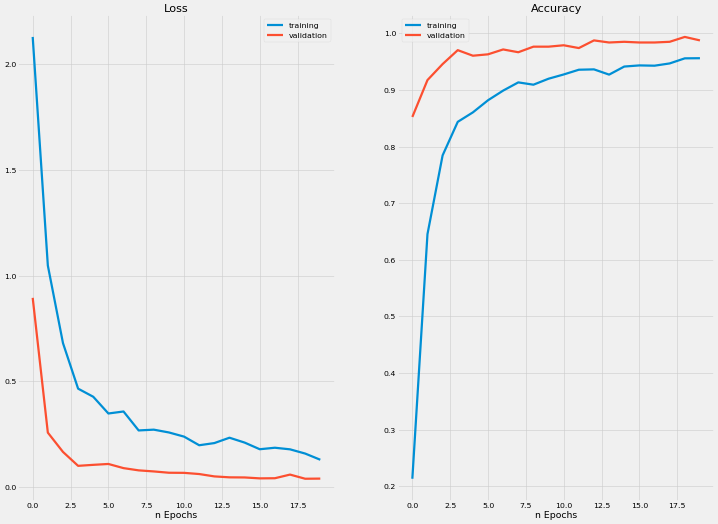

In [16]:
# print(cnn_history.history)
printHeadline('Training', 'Model Performance') 
nr,nc = 1, 2
plt.subplot(nr, nc, 1)
plt.plot( cnn_history.history['loss'])
plt.plot( cnn_history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('n Epochs')

plt.subplot(nr, nc, 2)
plt.plot( cnn_history.history['accuracy'])
plt.plot( cnn_history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('n Epochs')

plt.show();

In [17]:
printHeadline('Testing', 'Model Performance - Score') 
score = cnn_model.evaluate( x_test, y_test, verbose=0)
print( f'Test Score = {score[0]}' )
print( f'Test Accuracy = {score[1]}' )


------ 8. TESTING : Model Performance - Score ------
Test Score = 0.03577546830477897
Test Accuracy = 0.9906495809555054


In [18]:
# ## Save model for use
# import pickle
# FILE_MODEL = 'cnn_model.pkl'

# with open( FILE_MODEL, 'wb') as fd:
#     pickle.dump( cnn_model, fd)


## 3. Use Trained Model


In [19]:
# # Load model from file

# with open( FILE_MODEL, 'rb') as fd:
#     cnn_model_s = pickle.load( fd)


In [20]:
## Resize image, 
def preprocess_scan_image(img, kern=(5,5), blursig=1, dil_iterz=1):    
    # b. grayscale it for filterz
    gimg = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY )
    
    # c. blur and edge detect
    img_edgez = cv2.Canny( cv2.GaussianBlur(gimg, kern, blursig), 200, 200)
    img_edgez = cv2.erode( 
            cv2.dilate(img_edgez, np.ones(kern), iterations=dil_iterz), 
            np.ones(kern), iterations=1)
    
    return img_edgez


## Seek contour and bounding box of the doc - doc is assumed to be largest contour
def get_doc_contour_and_bbox(mask_img, out_img, athresh=1000, tfact=0.02):
    contz, hier = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE ) 
    
    x, y, w, h = 0, 0, 0, 0
    
    max_area = 0
    biggest_obj = None
    
    # a. identify doc contour and box as largest object
    for c in contz:
        a = cv2.contourArea( c )
        if a > athresh:
#             cv2.drawContours( out_img, c, -1, (200,0,255), 3)
            peri = cv2.arcLength(c, True )
            appx = cv2.approxPolyDP(c, tfact*peri, True)
            
            if len(appx) == 4 and a > max_area: ## is a rect and is larger
                biggest_obj = appx
                max_area = a
                
    # b. draw bounding box on identified document 
    if not biggest_obj is None:
        x, y, w, h = cv2.boundingRect( biggest_obj )
        cv2.rectangle( out_img, (x, y), (x+w, y+h), (200,0,255), 3)
    
    ## c. return bounding box of doc
    #return x, y, w, h
    return biggest_obj


In [34]:
## Webcam View
fW, fH = 640, 480
cap = cv2.VideoCapture( 0 )
cap.set(3, fW)
cap.set(4, fH)
# cap.set(10, 150)

digitz_collected = []

while cap.isOpened(): ## go frame by frame
    success, img = cap.read()
    if success:                
        # b. preprocess
        img_edgez = preprocess_scan_image( img , dil_iterz=2)
        
        # c. get contours. Seeking largest object detected as doc
        biggest_approx = get_doc_contour_and_bbox( img_edgez, img) 

        cv2.imshow( 'Digit OCR', img)
        
        if not biggest_approx is None:
            x, y, w, h = cv2.boundingRect( biggest_approx )
            # a. crop selection, convert_to_ndarray and reshape 
            out_img = img[y:y+h, x:x+w]
            digitz_collected.append( out_img)
            if out_img.shape[0] > 100:
    #             out_img = img.copy()
    #             print(out_img.shape)
                out_img = preprocess( cv2.resize(out_img, (32, 32)) ) #, interpolation=cv2.INTER_AREA) )                
                out_img = np.asarray(out_img) 
                out_img = out_img.reshape( 1, 32, 32, 1)
                # b. predict 
                pred_y_prob = np.amax( cnn_model.predict(out_img) )
                if pred_y_prob > 0.3:
                    pred_y_index = int(cnn_model.predict_classes( out_img ) )
                    msg = f"Predicted: i = {pred_y_index}, p(x)={pred_y_prob}" #, class={y_labelz[pred_y_index]}
                    _ = cv2.putText(img, msg, (25,200), cv2.FONT_HERSHEY_COMPLEX, 1, (10,235,10), 2)
                    _ = cv2.putText(out_img, msg, (10,10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,0), 1)
                else:
                    msg = "Not clear what digit it is"
                    _ = cv2.putText(img, msg, (25,200), cv2.FONT_HERSHEY_COMPLEX, 1, (10,10,235), 2)
            #print(msg)
        # c. update screen
        cv2.imshow( 'Digit OCR', img)
        
    if cv2.waitKey(30) & 0xFF == 27: ##ESC  # 1 == ord('q'):
        break

cv2.destroyAllWindows()    
cap.release()

True

True

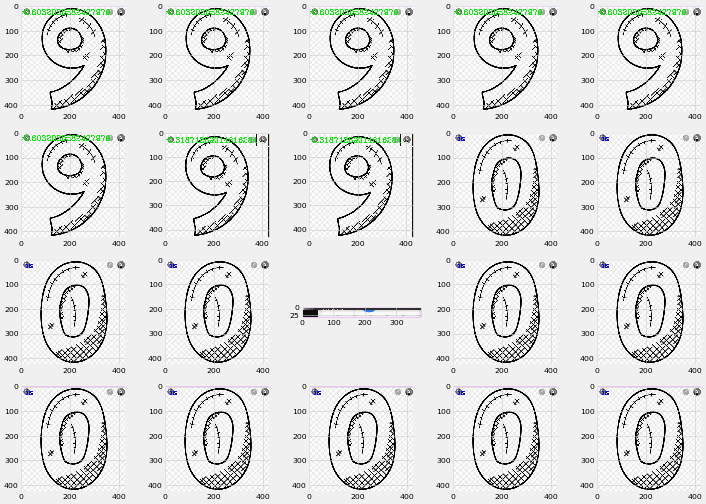

In [35]:
grid_plot_images(digitz_collected[-100:-80], logit=False, nc=5)